In [1]:
# Copyright (c) 2023, ISCS, Wenjie Zhang.
#
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.

from __future__ import absolute_import, division, print_function, unicode_literals

import argparse

import builtins
import datetime
import json
import sys
import time

import numpy as np
import torch

from dsmeasure2.core.dsm_device_mng   import DeviceManager
from dsmeasure2.core.dsm_operator_mng import OperatorManager

from dsmeasure2.core.dsm_tensor   import AbstractTensor
from dsmeasure2.core.dsm_device   import AbstractDeviceConfig, AbstractDevice
from dsmeasure2.core.dsm_operator import AbstractOperatorConfig, \
                                         AbstractOperator, \
                                         OperatorComputationalConfig, \
                                         OperatorNonComputationalConfig , \
                                         OperatorCustomConfig , \
                                         OpStaticComputational , \
                                         OpStaticNonComputational, \
                                         OpStaticDerivative

from dsmeasure2.device.device_cuda import DeviceCUDA, DeviceCUDAConfig
from dsmeasure2.device.device_pcie import DevicePCIE4, DevicePCIEConfig

from dsmeasure2.core.dsm_tensor_mng    import TensorManager
from dsmeasure2.graph.tensor_define    import ActivationTensor, WeightTensor, TensorState
from dsmeasure2.graph.operator_graph   import UnaryOperator, BinaryOperator, TernaryOperator, InitiateOperator
from dsmeasure2.graph.unary_operator   import make_linear, make_layernorm, make_dropout, make_gelu, make_softmax
from dsmeasure2.graph.binary_operator  import make_add, make_matmul
from dsmeasure2.graph.operator_attn    import make_attn_tp, AttentionTPCRParallel, AttentionTPCRParallelBackward
from dsmeasure2.graph.dsm2_transformer import make_ffn_gpt2, FeedForwardGPT2, FeedForwardGPT2Backward, \
                                              make_transformer_block, TransformerBlockGPT2, TransformerBlockGPT2Backward
from dsmeasure2.graph.gpt2_sequence    import make_gpt_2
from dsmeasure2.engine import CostEngine

In [2]:
gpt2 = make_gpt_2(
        compute_time_linear_qkv=490,
        compute_time_matmul_kq=214, 
        compute_time_sm=163,
        compute_time_attention_dropout=286,
        compute_time_matmul_v=191,
        compute_time_linear=146,
        compute_time_dropout_attn=140,

        compute_time_linear_qkv_backward=340,
        compute_time_matmul_kq_backward=531,
        compute_time_sm_backward=212,
        compute_time_attention_dropout_backward=248,
        compute_time_matmul_v_backward=360,
        compute_time_linear_backward=250,
        compute_time_dropout_attn_backward=155,

        compute_time_allreduce_attn=2200,

        compute_time_linear_1=512,
        compute_time_gelu=428,
        compute_time_linear_2=483,
        compute_time_dropout_ffn=75,
        
        compute_time_linear_1_backward=442,
        compute_time_gelu_backward=210,
        compute_time_linear_2_backward=100,
        compute_time_dropout_ffn_backward=102,

        compute_time_allreduce_ffn=2200,
        
        compute_time_layernorm_1=67,
        compute_time_layernorm_2=67,
        compute_time_residual_add_1=67,
        compute_time_residual_add_2=67,

        compute_time_layernorm_1_backward=236,
        compute_time_layernorm_2_backward=236,

        compute_time_loss_with_backward=12000,

        batch_size=8,
        seq_len=1024,
        hidden_size=1792,
        head_num=16,
        head_hidden_size=112,
        tensor_parallel=2,
        precision=2,

        transfomer_block_num=2
    )
for _op in gpt2:
        OperatorManager().register(_op)

In [3]:
DeviceManager().register(DeviceCUDAConfig(memory_max_capacity=40000, memory_limit_capacity=40000))
DeviceManager().register(DevicePCIEConfig())
CostEngine().evaluation(10, [_op._config.op_uid for _op in gpt2])

<operator-64, init_fn>
<operator-65, transformer_block_gpt2>
<operator-67, attention_tpcr_parallel>
<operator-69, matmul_qk>
<operator-70, softmax_forward>
<operator-71, dropout_forward>
<operator-72, matmul_v>
<operator-73, linear_forward>
<operator-74, allreduce_forward>
<operator-75, output_dropout>
<operator-76, add_forward>
<operator-77, layernorm_forward>
<operator-78, ffn_gpt2>
<operator-80, gelu_forward>
<operator-81, linear_2_forward>
<operator-82, allreduce_forward>
<operator-83, dropout_forward>
<operator-84, add_forward>
<operator-85, transformer_block_gpt2>
<operator-87, attention_tpcr_parallel>
<operator-89, matmul_qk>
<operator-90, softmax_forward>
<operator-91, dropout_forward>
<operator-92, matmul_v>
<operator-93, linear_forward>
<operator-94, allreduce_forward>
<operator-95, output_dropout>
<operator-96, add_forward>
<operator-97, layernorm_forward>
<operator-98, ffn_gpt2>
<operator-100, gelu_forward>
<operator-101, linear_2_forward>
<operator-102, allreduce_forward>


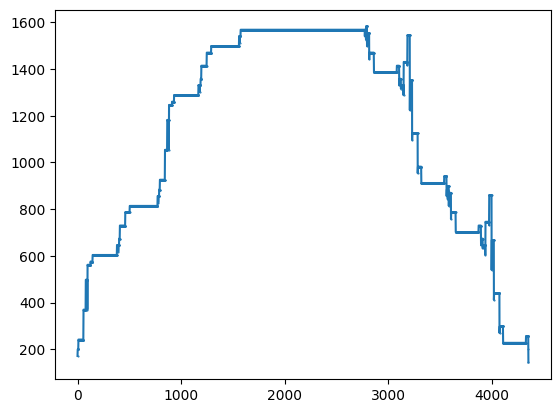

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
# plt.figure(figsize=(100,40))
plt.plot(list(range(len(CostEngine().cuda_memory_trace))), CostEngine().cuda_memory_trace, '.-', markersize=1)

In [6]:
from dsmeasure2.flatten.flatten import flatten
seq2 = flatten([_op._config.op_uid for _op in gpt2], [0], False)
print(seq2)

[64]
